Reference:

https://levity.ai/blog/what-is-topic-modeling#:~:text=Topic%20modeling%20is%20a%20type,predefined%20tags%20or%20training%20data

https://cohere.com/blog/topic-modeling-with-bertopic?utm_source=google&utm_medium=cpc&utm_campaign=fy25_amer_1_awareness_paidsearch_22285080165_179273636361_737093627743&utm_term={querystring}&gad_source=5&gclid=EAIaIQobChMI38yMooeJjAMVAxJECB3ejAybEAAYAyAAEgJNq_D_BwE

In [64]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

### Topic Modelling:

Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT.

### Load Transcripts Data from Kafka Stream (PySpark)

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, FloatType, IntegerType

In [5]:
spark = SparkSession.builder \
    .appName("YouTubeTranscriptAnalysis") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/kafka_checkpoint") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.4") \
    .getOrCreate()

In [6]:
transcripts_schema = StructType([
    StructField("videoId", StringType(), True),
    StructField("transcript", ArrayType(StructType([
        StructField("text", StringType(), True),
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True)
    ])), True)
])

In [7]:
kafka_transcripts_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "youtube_transcripts") \
    .option("startingOffsets", "earliest") \
    .load()

In [8]:
transcripts_parsed_df = kafka_transcripts_df \
    .selectExpr("CAST(value AS STRING)") \
    .select(from_json(col("value"), transcripts_schema).alias("data")) \
    .select("data.videoId", "data.transcript")

In [16]:
transcripts = transcripts_parsed_df \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("transcripts_table") \
    .start()

transcripts.awaitTermination(10)

25/03/14 00:14:56 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/14 00:14:56 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [18]:
transcripts_df = spark.sql("SELECT * FROM transcripts_table")

In [19]:
def concatenate_transcript(transcript):
    if transcript is not None:
        return " ".join([t["text"] for t in transcript if t["text"] is not None])
    return ""

concat_udf = udf(concatenate_transcript, StringType())

In [20]:
transcripts_df = transcripts_df.withColumn("full_transcript", concat_udf(col("transcript"))).select("videoId", "full_transcript")

transcripts_pd = transcripts_df.toPandas()

### Preprocess Transcript Text

In [46]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import numpy as np

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bharathvelamala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bharathvelamala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Need to expand the contractions for better analysis 

In [22]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    if not text:
        return ""
    text = re.sub(r"\W", " ", text.lower()) 
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

transcripts_pd["cleaned_transcript"] = transcripts_pd["full_transcript"].apply(preprocess_text)

In [43]:
import wordcloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

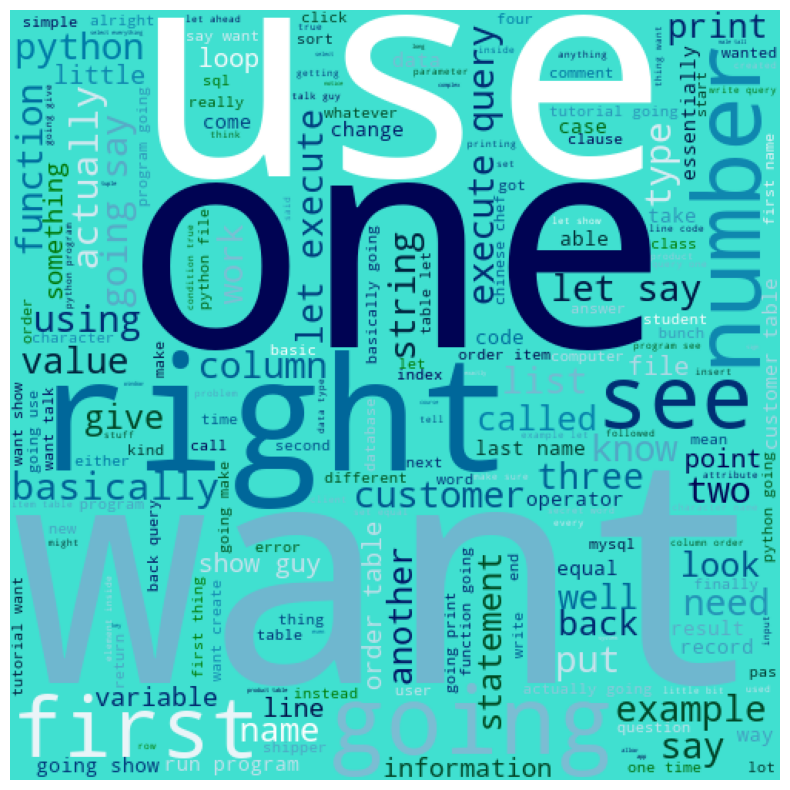

In [45]:
transcript_data = ""
for data in transcripts_pd["cleaned_transcript"]:
    transcript_data = transcript_data+" "+data

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(transcript_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Apply Topic Modeling (LDA)

**Latent Dirichlet Allocation[LDA]:**

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically.

This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

In [47]:
tokenize_trascript = transcripts_pd.cleaned_transcript.apply(lambda x : x.split())

In [48]:
id2word = corpora.Dictionary(tokenize_trascript)

In [49]:
texts = tokenize_trascript
corpus = [id2word.doc2bow(text) for text in texts]

In [59]:
# building LDA model

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='symmetric',
    eta='symmetric',
    per_word_topics=True
)

In [60]:
pprint(lda_model.print_topics())

[(0,
  '0.017*"number" + 0.012*"one" + 0.010*"machine" + 0.010*"like" + 0.010*"set" '
  '+ 0.009*"system" + 0.009*"steal" + 0.008*"sign" + 0.007*"gödel" + '
  '0.007*"could"'),
 (1,
  '0.031*"table" + 0.027*"order" + 0.027*"let" + 0.025*"customer" + '
  '0.022*"query" + 0.022*"column" + 0.015*"name" + 0.014*"get" + 0.014*"use" + '
  '0.013*"going"'),
 (2,
  '0.045*"going" + 0.022*"say" + 0.022*"like" + 0.020*"want" + 0.019*"python" '
  '+ 0.015*"inside" + 0.014*"could" + 0.013*"function" + 0.012*"basically" + '
  '0.011*"one"')]


In [61]:
doc_lda = lda_model[corpus]

### Visualize Topics

In [62]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.006797 -0.158980       1        1  55.581483
1     -0.174256  0.084052       2        1  34.767636
0      0.181053  0.074928       3        1   9.650882, topic_info=          Term        Freq       Total Category  logprob  loglift
2547     table  853.000000  853.000000  Default  30.0000  30.0000
287   customer  677.000000  677.000000  Default  29.0000  29.0000
2433     query  593.000000  593.000000  Default  28.0000  28.0000
208     column  607.000000  607.000000  Default  27.0000  27.0000
840      order  866.000000  866.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
598      input   30.308086  154.750958   Topic3  -5.5113   0.7077
1235       two   31.396098  450.052404   Topic3  -5.4760  -0.3246
1298      work   28.586381  156.034065   Topic3  -5.5698   0.6410
950   question   28.888096  219.997955   Topic3  -5.5593   0.3079
487        get   28.328493  720.144704   Topic3  -5.5789  -0.8975

[210 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2050      2  0.982604     1990
19        1  0.922431     able
19        2  0.023774     able
19        3  0.057058     able
21        1  0.974505  academy
...     ...       ...      ...
1302      2  0.052869    would
1302      3  0.195615    would
1318      1  0.780637     zero
1318      2  0.005698     zero
1318      3  0.216527     zero

[367 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

To measure how good is our model we can use perplexity score and coherence socre. The lower score of perplexity is better for the model.

In [63]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_trascript, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -6.0174429019261515

Coherence Score:  0.42191166086479964


### Track with MLflow

In [38]:
# import mlflow
# import mlflow.sklearn

# mlflow.set_experiment("YouTube Topic Modeling")

# with mlflow.start_run():
#     mlflow.log_param("n_topics", 5)
#     mlflow.sklearn.log_model(lda, "LDA_model")
#     mlflow.log_artifact("lda_visualization.html")